In [1]:
import cv2
import numpy as np
import os
from PIL import Image
import math
import requests
import zipfile
import io
from io import BytesIO
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from google.colab.patches import cv2_imshow
#from google.colab import drive

In [2]:
# Configurar los generadores de datos
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

In [3]:
# URL del archivo ZIP específico en el repositorio
file_url = 'https://github.com/satencio/DatasetImagenes/raw/main/Part.zip'
response = requests.get(file_url)

In [4]:
# Guarda el archivo ZIP localmente
zip_path = '/content/Part.zip'
with open(zip_path, 'wb') as file:
    file.write(response.content)

In [5]:
# Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [6]:
# Validar imágenes en los subdirectorios
data_dir = 'Part'
subdirs = ['Piezas con corrosion', 'Piezas sin corrosion']
for subdir in subdirs:
    dir_path = os.path.join(data_dir, subdir)
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        try:
            with Image.open(file_path) as img:
                img.verify()
        except (IOError, SyntaxError) as e:
            print(f'El archivo {file_path} es inválido: {e}')

In [7]:
# Generadores de entrenamiento y validación
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 33 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


In [8]:
# Definir el modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Entrenar el modelo

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
2/2 [==============================] - 9s 926ms/step - loss: 0.6970 - accuracy: 0.4242 - val_loss: 0.7980 - val_accuracy: 0.5714
Epoch 2/10
2/2 [==============================] - 2s 277ms/step - loss: 0.7992 - accuracy: 0.5455 - val_loss: 0.7262 - val_accuracy: 0.5714
Epoch 3/10
2/2 [==============================] - 1s 1s/step - loss: 0.9941 - accuracy: 0.5455 - val_loss: 0.8567 - val_accuracy: 0.5714
Epoch 4/10
2/2 [==============================] - 1s 140ms/step - loss: 0.9140 - accuracy: 0.5455 - val_loss: 0.6728 - val_accuracy: 0.5714
Epoch 5/10
2/2 [==============================] - 1s 206ms/step - loss: 0.7462 - accuracy: 0.5455 - val_loss: 0.6058 - val_accuracy: 0.5714
Epoch 6/10
2/2 [==============================] - 1s 232ms/step - loss: 0.6248 - accuracy: 0.5758 - val_loss: 0.5702 - val_accuracy: 0.7143
Epoch 7/10
2/2 [==============================] - 2s 465ms/step - loss: 0.5909 - accuracy: 0.7879 - val_loss: 0.5755 - val_accuracy: 1.0000
Epoch 8/10
2/2 [=======

In [10]:
# Evaluar el modelo
validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)
loss, accuracy = model.evaluate(validation_generator, steps=validation_steps)
print(f'Accuracy: {accuracy * 100:.2f}%')


1/1 [==============================] - 0s 304ms/step - loss: 0.3224 - accuracy: 0.8571
Accuracy: 85.71%


In [11]:
# Encuentra el índice de la capa 'flatten'
flatten_layer_index = None
for i, layer in enumerate(model.layers):
    if 'flatten' in layer.name:
        flatten_layer_index = i
        break

In [12]:
# Crear un extractor de características
#feature_extractor = Model(inputs=model.input, outputs=model.get_layer('flatten_2').output)
if flatten_layer_index is not None:
    # Crear un nuevo modelo basado en las capas del modelo CNN
    feature_extractor = Model(inputs=model.input, outputs=model.layers[flatten_layer_index].output)


In [13]:
# Función para extraer características de una imagen usando el modelo CNN
def extract_features_cnn(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error al cargar la imagen.")
        return None
    image = cv2.resize(image, (64, 64))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    features = feature_extractor.predict(image)
    return features.flatten()

In [14]:
# Directorio de datos de entrenamiento
train_dir = 'Part'

In [15]:
# Lista para almacenar características y etiquetas
X_train_features = []
y_train = []

In [16]:
# Recorrer todas las imágenes en el directorio de entrenamiento
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        label = 1 if subdir == 'Piezas con corrosion' else 0
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            features = extract_features_cnn(file_path)
            if features is not None:
                X_train_features.append(features)
                y_train.append(label)

1/1 [==============================] - 0s 67ms/step


In [17]:
# Convertir a numpy arrays
X_train_features = np.array(X_train_features)
y_train = np.array(y_train)
print(f'Forma de X_train_features: {X_train_features.shape}')


Forma de X_train_features: (40, 4608)


In [18]:
# Entrenar el modelo SVC
model_svc = SVC(kernel='linear')
model_svc.fit(X_train_features, y_train)

SVC(kernel='linear')

In [19]:
# Función de predicción
def detectar_corrosion(imagen_path):
    features = extract_features_cnn(imagen_path)
    if features is None:
        return
    features = features.reshape(1, -1)
    prediction = model_svc.predict(features)[0]
    if prediction == 1:
        print("Se detectó corrosión.")
    else:
        print("No se detectó corrosión.")

    imagen_cv2 = cv2.imread(imagen_path)
    if imagen_cv2 is not None:
        cv2_imshow(imagen_cv2)
    else:
        print("Error al cargar la imagen.")

In [20]:
def procesar_imagen(url, nombre_archivo):
    # Descargar la imagen
    response = requests.get(url)
    imagen = Image.open(BytesIO(response.content))
    imagen.save(nombre_archivo)
    detectar_corrosion(nombre_archivo)
#   mostrar_imagen(nombre_archivo)

1/1 [==============================] - 0s 36ms/step
No se detectó corrosión.


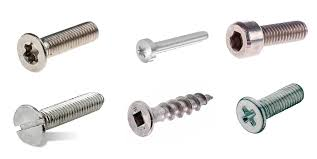

1/1 [==============================] - 0s 52ms/step
Se detectó corrosión.


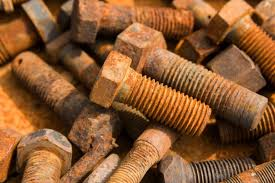

1/1 [==============================] - 0s 40ms/step
Se detectó corrosión.


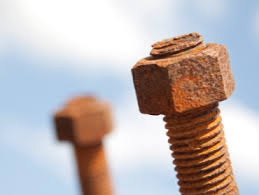

1/1 [==============================] - 0s 48ms/step
No se detectó corrosión.


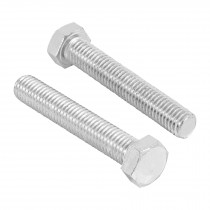

In [21]:
# Lista de URLs y nombres de archivo correspondientes
url1='https://raw.githubusercontent.com/PieroTejada/ImagenesPruebaVision/main/Pruebas/variostornillos.png'
url2='https://raw.githubusercontent.com/PieroTejada/ImagenesPruebaVision/main/Pruebas/tornillosoxidados3.png'
url3='https://raw.githubusercontent.com/PieroTejada/ImagenesPruebaVision/main/Pruebas/Prueba2.png'
url4='https://www.truper.com/media/product/e02/tornillos-tipo-maquina-de-7-16-a-3-4-a43.jpg'

procesar_imagen(url1, 'prueba1.png')
procesar_imagen(url2, 'prueba2.png')
procesar_imagen(url3, 'prueba3.png')
procesar_imagen(url4, 'prueba4.png')
